In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
import scipy

import warnings
warnings.filterwarnings("ignore")

In [2]:
# verinin okunması : 

data = pd.read_csv("train.csv")
df = data.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
# sayısal veri içerdikleri için numerik gözüken değişkenlerin tipini kategorik tipine (object) çevrilmesi : 

df.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']] = df.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']].astype('object')

<AxesSubplot:>

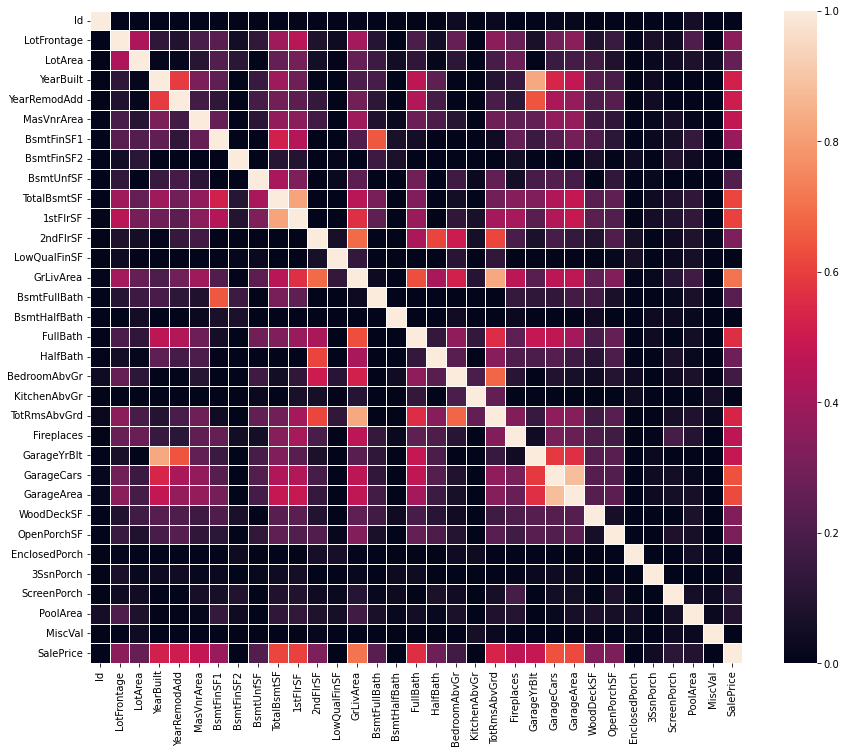

In [4]:
# numerik değişkenler arasındaki korelasyonlara hızlı bir bakış : 

corr = df.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr,linewidths=.5, vmin=0, vmax=1, square=True)

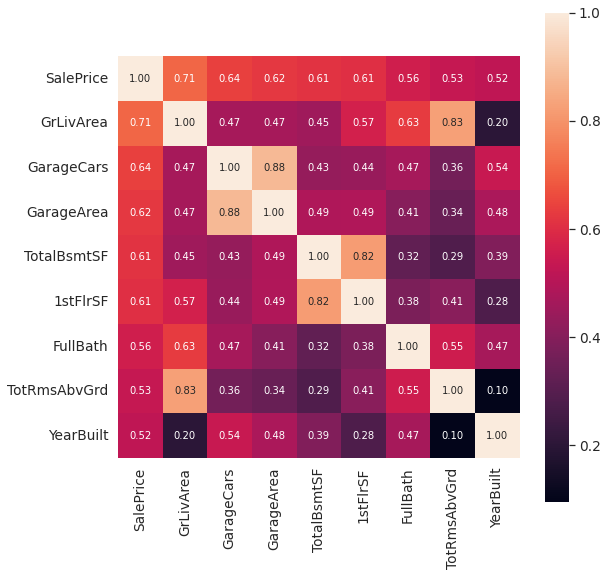

In [5]:
# saleprice korelasyon matrisi:

k = 9 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [6]:
# yüzdesel olarak eksik verilerin kontrolü: 

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


### Edinilen bu bilgiler ışığında, "PoolQC","MiscFeature","Alley","Fence" ve "FireplaceQu" değişkenleri :

### 1- yüzdesel olarak fazlaca eksik değere sahip olduğu için 
### 2- saleprice değişkenini çok fazla etkilemeyeceği düşünüldüğü için

### Veri setinden çıkarılmasına karar verilmiştir. 


In [7]:
# veri setinden çıkarılacak değişkenlerin çıkarılması: 

df=df.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1)

In [8]:
# numerik ve kategorik olan kolonları ayrı değişkenlere atanması:

num_col=df._get_numeric_data().columns.tolist()
cat_col=set(df.columns)-set(num_col)

In [9]:
# incelememiz gereken diğer değişkenleri görmek için tekrar eksik veri tablosunun gösterimi:

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342


## Feature Engineering Bölümü (daha basic bir isim bulunabilir.. veri setinin hazırlanması tarzında bir şey) 

Lot frontage ile ilgili bir iki bilgi yaz

In [10]:
# lot frontage

df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

Bath ile ilgili bir iki bilgi yaz

In [11]:
# bathX 

df['TotalBath'] = df['FullBath'] + (0.5*df['HalfBath']) + df['BsmtFullBath'] + (0.5*df['BsmtHalfBath'])
df = df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis = 1)


GarageX ile ilgili açıklamalar yapılacak ve tekrar gözden geçirilmesi gerek

In [12]:
# garageX
df["GarageCars"].fillna("No Garage")
df["GarageArea"].fillna("No Garage")

df['GarageCond'].fillna('No Garage', inplace=True)
df['GarageType'].fillna('No Garage', inplace=True)
df['GarageYrBlt'].fillna('Unknown', inplace=True)
df['GarageFinish'].fillna('No Garage', inplace=True)
df['GarageQual'].fillna('No Garage', inplace=True)

BasementX ile ilgili açıklamalar yapılacak ve tekrar gözden geçirilmesi gerek

In [13]:
# basementX 

df['BsmtExposure'].fillna('No Basement', inplace=True)
df['BsmtFinType2'].fillna('No Basement', inplace=True)
df['BsmtFinType1'].fillna('No Basement', inplace=True)
df['BsmtCond'].fillna('No Basement', inplace=True)
df['BsmtQual'].fillna('No Basement', inplace=True)

Conditionla ilgili yaz

In [ ]:
#Condition kolonlarının düzenlenmesi:

df[["Condition1","Condition2", "SalePrice"]].head(100)

In [14]:
# condition1

df["Condition1"].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [16]:
# condition2

df["Condition2"].value_counts()

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [17]:
# condition2 değişkeni çıkarıldı, condition1 değişkeninin adı "condition" olarak değiştirildi:

df.drop("Condition2", axis=1, inplace=True)
df.rename(columns={"Condition1": "Condition"}, inplace=True)


masvnrarea'nın nan değerlerine bakılacak

In [18]:
# masvnr

df["MasVnrType"].fillna('Unknown', inplace=True)
df["MasVnrType"].replace('None', 'Unknown',inplace=True)

df["MasVnrArea"].replace(0.0, 'Unknown',inplace=True)

In [19]:
# electrical :

df = df.drop(df.loc[df['Electrical'].isnull()].index)

In [20]:
# 1stFlrSF ve 2ndFlrSF değişkenlerinin toplamı GrLivArea değişkenini verdiği için bu iki değişken veri setinden çıkarıldı: 

#1. kat alanı ve 2. kat alanı GrLivArea'yı verdiği için iki kolon da silindi.
df.drop(["1stFlrSF","2ndFlrSF"], axis=1, inplace=True)

In [21]:
# veri setinin son hali : 

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalBath
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,0,1710,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,3.5
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,Unknown,Unknown,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,0,1262,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,2.5
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,0,1786,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,3.5
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,Unknown,Unknown,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,0,1717,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,2.0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,0,2198,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,3.5
